In [1]:
import pandas
import math
import parse
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
%matplotlib inline

#import process
%load_ext Cython

#%%cython
########################################################
evidence_file = 'data/evidence.txt'
filtered_evidence_file = 'data/evidence_filtered.txt'
protein_groups_file = 'data/proteinGroups.txt'
phospho_peptide_file = 'data/Phospho (STY)Sites.txt'
our_group_name = 'PYND'
other_group_names = ['APUBSCRAWL', 'ONION', 'ET0H', 'SHMOO', 'WHANGEE'] # Case doesn't matter

experiment_ext_names = ['Ub', 'UbP', 'WCL', 'WCLP']


########################################################

In [2]:

# Now apply the filter to evidence.txt to get evidence_filtered.tsv
# This should keep only the lines for our group
parse.filter_tsv(evidence_file, filtered_evidence_file, 'Experiment', '^[Pp][Yy][Nn][Dd]')
print('Done.')

Done.


In [3]:
evidence = parse.parse_evidence(filtered_evidence_file)

protein_groups = parse.parse_protein_groups(protein_groups_file)
#protein_groups = parse.remove_cols(protein_groups, other_group_names)

phospho = parse.parse_phosphosites(phospho_peptide_file)
#phospho = parse.remove_cols(phospho, other_group_names)
print("Done.")

/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (421,422) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)
/Users/student/anaconda/lib/python3.4/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (211,677,678) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


Done.


In [4]:
def calc_epsilon(protein_groups):
    mins=[]
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext):
                miny=float("inf")
                for x in protein_groups[col]:
                    x = float(x)
                    if x < miny and x != 0.0:
                        miny = x
                if miny != 0.0:
                    mins.append(miny)
    return min(mins)
epsilon = calc_epsilon(protein_groups)
epsilon

6193.8

In [5]:
# What's the distribution of intensities?
def get_intensity_dists(protein_groups, exp_type, cutoff=0):
    intensities=[]
    experiments=[]
    for col in protein_groups.columns:
        for exp_ext in experiment_ext_names:
            if 'Intensity' in col and col.endswith(exp_ext) and 'KO' in col:
                t = col.split('_')[-1] # to get sorting of keys right
                if t == exp_type:
                    protein_groups = protein_groups[protein_groups[col] > cutoff]
                    protein_groups = protein_groups[protein_groups[col] < float('Inf')]
                    intensities.extend(protein_groups[col])
                    for i in protein_groups[col]:
                        experiments.append(col.split(' ')[1])
    return pandas.DataFrame({"intensity": intensities, "experiment": experiments})

get_intensity_dists(protein_groups.copy(), 'WCL').head()

,experiment,intensity
0,Apubscrawl_Swe1KO_WCL,35874000
1,Apubscrawl_Swe1KO_WCL,6339500
2,Apubscrawl_Swe1KO_WCL,132750000
3,Apubscrawl_Swe1KO_WCL,2717800
4,Apubscrawl_Swe1KO_WCL,4767800


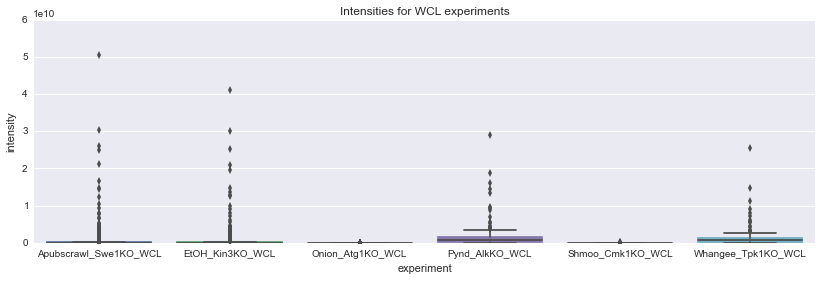

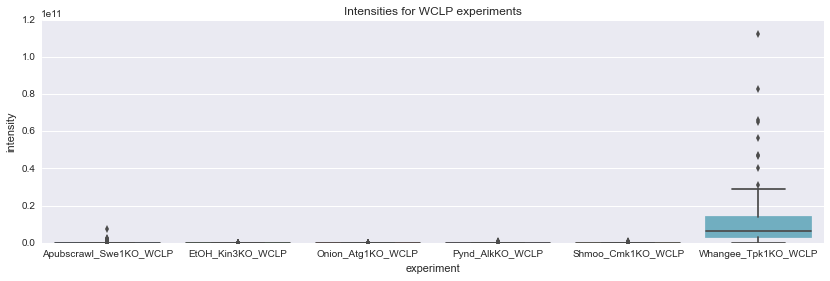

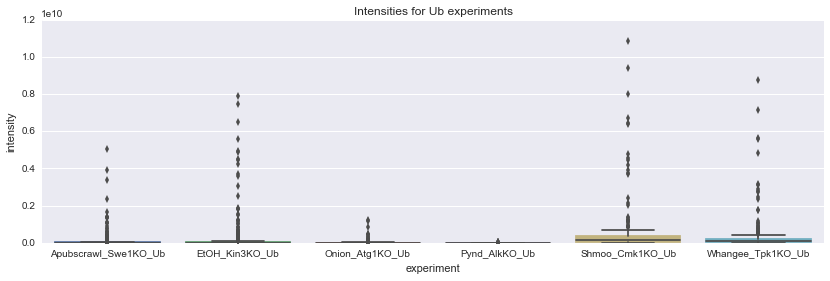

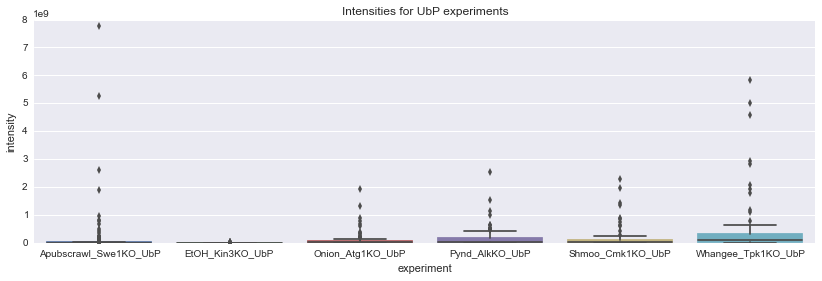

In [6]:
from scipy import stats
sns.set(rc={"figure.figsize": (14, 4)})
def plot_for_exp(exp_type):
    intensities = get_intensity_dists(protein_groups.copy(), exp_type)
    #sns.distplot(intensities['intensity'], kde=False, rug=False, label=exp_type, bins = 40);
    ax = sns.boxplot(x='experiment', y='intensity', data=intensities);
    #sns.axlabel("intensity", "frequency")
    plt.title("Intensities for %s experiments" % exp_type)
    #plt.legend(loc='upper left')
    plt.show()

plot_for_exp('WCL')
plot_for_exp('WCLP')
plot_for_exp('Ub')
plot_for_exp('UbP')

In [7]:
def filter_bad_rows(df):

    def filter_out(prefix):
        return df[df.apply(lambda row: not any([prefix in name for name in row['Protein IDs']]), axis=1)]

    df = filter_out('CON_')
    df = filter_out('REV_')
    return df

def logspace(pg, cols, strict_cutoff=0):
    for col in cols:
        pg = pg[pg[col].map(lambda x: abs(x) > strict_cutoff)]
        pg = pg[pg[col] < float('Inf')]
        pg[col] = pg[col].map(lambda x: math.log(x, 2) if x > epsilon else epsilon)
    return pg

def normalize(pg, top_col, bottom_col, cutoff=10**5):
    pg = pg[pg[top_col] > math.log(cutoff, 2)]
    pg = pg[pg[bottom_col] > math.log(cutoff, 2)]
    pg['diff'] = pg[top_col] - pg[bottom_col]
    return pg

def spaceify(top_col, bottom_col, cutoff=10**5):
    pg = protein_groups.copy()
    pg = filter_bad_rows(pg)
    pg = logspace(pg, [top_col, bottom_col])
    pg = normalize(pg, top_col, bottom_col, cutoff)
    return pg[['Protein IDs', 'Fasta headers', 'diff', top_col, bottom_col]]

def get_top(pg):
    top = pg.sort('diff', 0, False)
    top = top[top['diff'] > math.log(4, 2)]
    return top # .set_index('Protein IDs')
    
def get_bottom(pg):
    bottom = pg.sort('diff', 0, True)
    bottom = bottom[bottom['diff'] < math.log(1/4, 2)]
    return bottom # .set_index('Protein IDs')

print("Done.")

Done.


/Users/student/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


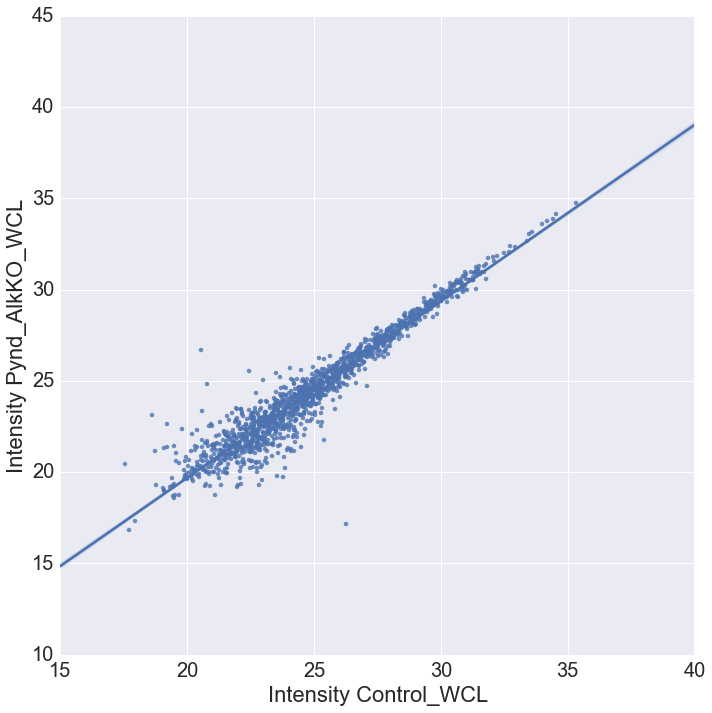

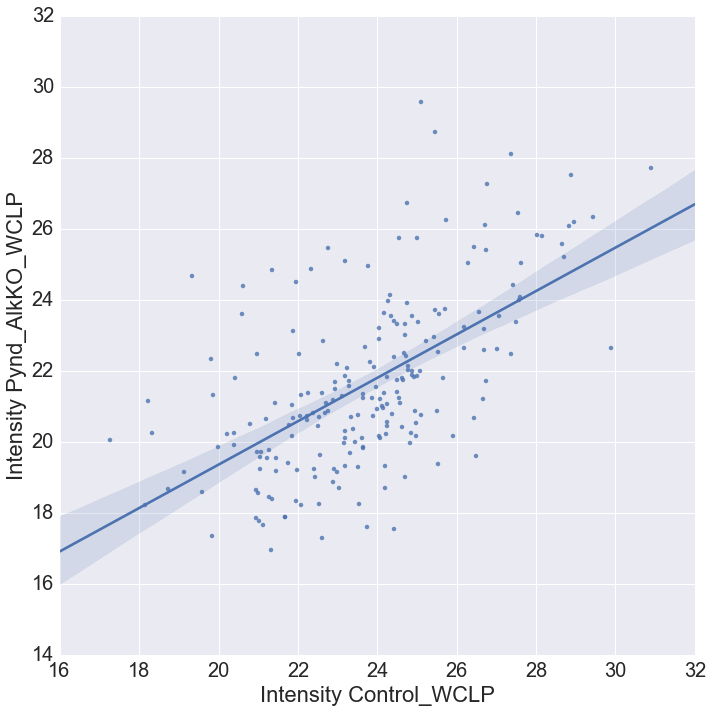

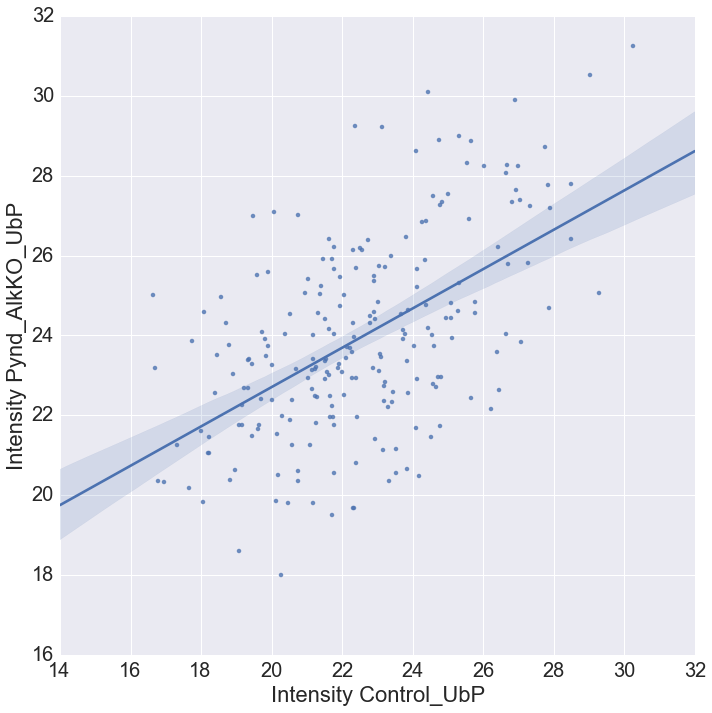

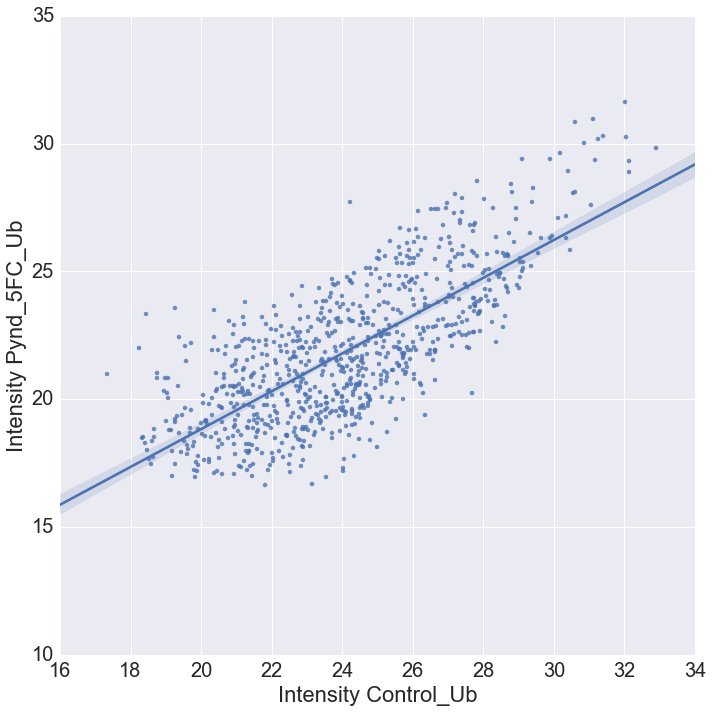

In [8]:

sns.set(rc={"figure.figsize": (12, 8)})
sns.set(font_scale=2)
def analyze(pg, top_col, bottom_col, cutoff=10**5):
    t = get_top(pg)
    b = get_bottom(pg)
    g = sns.lmplot(x=bottom_col, y=top_col, data=pg, size=10); # , y_jitter=.03
    plt.savefig("results/" + top_col + ".png")
    #g.set(xlim=(math.log(epsilon, 2), ))
    #g.set(ylim=(math.log(epsilon, 2), ))
    t.to_csv('results/top_' + top_col + '.csv')
    b.to_csv('results/bottom_' + top_col + '.csv')
    return t, b
    

ko = spaceify('Intensity Pynd_AlkKO_WCL', 'Intensity Control_WCL')
top_ko, bottom_ko = analyze(ko, 'Intensity Pynd_AlkKO_WCL', 'Intensity Control_WCL')

wclp = spaceify('Intensity Pynd_AlkKO_WCLP', 'Intensity Control_WCLP')
top_wclp, bottom_wclp = analyze(wclp, 'Intensity Pynd_AlkKO_WCLP', 'Intensity Control_WCLP')

ubp = spaceify('Intensity Pynd_AlkKO_UbP', 'Intensity Control_UbP')
top_ubp, bottom_ubp = analyze(ubp, 'Intensity Pynd_AlkKO_UbP', 'Intensity Control_UbP')

fc = spaceify('Intensity Pynd_5FC_Ub', 'Intensity Control_Ub')
top_5fc, bottom_5fc = analyze(fc, 'Intensity Pynd_5FC_Ub', 'Intensity Control_Ub')

exp_diffs = [ko, wclp, ubp, fc]

In [ ]:
#import wget
#wget.download('http://www.geneontology.org/ontology/obo_format_1_2/gene_ontology.1_2.obo')
#print("Done.")

In [9]:
# This doesn't work well
# We lose too many map entries this way

from goatools import go_enrichment
#from goatools import associations # broken

def get_uniprot_to_go(f):
    assoc = {}
    for line in open(f, 'r', encoding='latin1'):
        atoms = line.split()
        if atoms[0] == 'UniProtKB' and len(atoms) > 2 and atoms[3].startswith('GO:'):
            assoc[atoms[1]] = atoms[3]
    return assoc

def get_yeast_to_go(f, uniprot_to_go):
    assoc = {}
    for line in open(f, 'r'): # Q: are file handles closed with this?
        atoms = line.split()
        if atoms[2] in uniprot_to_go:
            for item in [s.strip() for s in atoms[1].split(';')]:
                assoc[item] = uniprot_to_go[atoms[2]]
    return assoc
    
# Downloaded from ftp://ftp.ebi.ac.uk/pub/databases/GO/goa/YEAST/
uniprot_to_go = get_uniprot_to_go('data/gene_association.goa_yeast.txt')

# Downloaded from http://www.uniprot.org/docs/yeast.txt, then header removed
yeast_to = get_yeast_to_go('data/yeast_ids.txt', uniprot_to_go)

print(len(yeast_to))

3771


In [11]:
#top_ko['GO'] = [yeast_to_uniprot[p] for p in top_ko['Protein IDs']]

#def append_go(row):
#    return [yeast_to_uniprot[i] if i in yeast_to_uniprot else None for i in row['Protein IDs']]
    # use [None, None] rather than [] to keep indicies the same between GO and Protein IDs (and Fasta headers)

#top_ko['GO'] = top_ko.apply(append_go, axis=1)
#top_ko[top_ko['GO'].apply(lambda terms: sum(1 for _ in filter(None, terms)) > 0)]

In [12]:
# Let's try using these:
# http://www.yeastgenome.org/download-data/curation

id_to_go = {}
for line in open('data/gene_association.sgd', 'r'):
    atoms = line.split()
    if atoms[0] == 'SGD':
        # 1 is the weird yeast ID (SGID), and 6 is the relation:
        # f = function
        # c = compartment
        # p = process
        id_to_go[(atoms[1], atoms[6])] = atoms[3]
print(len(id_to_go))
id_to_go

64240


{('S000002620', 'P'): 'GO:0006457',
 ('S000005713', 'C'): 'GO:0005739',
 ('S000001458', 'UniProtKB-KW:KW-0964'): 'GO:0005576',
 ('S000000718', 'UniProtKB-SubCell:SL-0086'): 'GO:0005737',
 ('S000003097', 'PANTHER:PTN000301682'): 'GO:0044822',
 ('S000004291', 'UniProtKB-KW:KW-0961'): 'GO:0071555',
 ('S000004239', 'UniProtKB-KW:KW-0699'): 'GO:0019843',
 ('S000005284', 'UniProtKB-KW:KW-0816'): 'GO:0006099',
 ('S000007380', 'UniProtKB-KW:KW-0511'): 'GO:0003824',
 ('S000002579', 'UniProtKB-KW:KW-0963'): 'GO:0005737',
 ('S000001541', 'UniProtKB-SubCell:SL-0191'): 'GO:0005634',
 ('S000005642', 'UniProtKB-KW:KW-0808'): 'GO:0016740',
 ('S000002217', 'C'): 'GO:0005737',
 ('S000005756', 'UniProtKB-KW:KW-0963'): 'GO:0005737',
 ('S000003071', 'F'): 'GO:0003723',
 ('S000000466', 'UniProtKB-KW:KW-0496'): 'GO:0005739',
 ('S000005429', 'C'): 'GO:0034967',
 ('S000006614', 'F'): 'GO:0030533',
 ('S000028421', 'UniProtKB-SubCell:SL-0191'): 'GO:0005634',
 ('S000006400', 'InterPro:IPR001138|InterPro:IPR020448

In [14]:
import re
pattern = re.compile('SGDID:(S\\d+)')
def get_sgids(lst):
    sgids = []
    for s in lst:
        match = pattern.search(s)
        if match is not None:
            sgids.append(match.group(1))
    return sgids

assert ['S000001611'] == get_sgids(['[>YKL128C PMU1 SGDID:S000001611, Chr XI'])

def get_go_terms(row, rel):
    terms = []
    for sgid in get_sgids(row['Fasta headers']):
        if (sgid, rel) in id_to_go:
            terms.append(id_to_go[(sgid, rel)])
    return terms

print("Done.")

Done.


In [15]:
from goatools import obo_parser
obo = obo_parser.GODag('gene_ontology.1_2.obo')
print("Done.")

load obo file gene_ontology.1_2.obo
45670

Done.


 nodes imported


In [33]:
def add_go_descs(row, rel_long, rel_short):
    lst = []
    for term in row['GO ' + rel_long]:
        if term in obo:
            lst.append(obo[term].name)
    return lst

def show_go(exp_diff):
    exp_diff['GO components'] = exp_diff.apply(lambda row: get_go_terms(row, 'C'), axis=1)
    exp_diff['GO functions'] = exp_diff.apply(lambda row: get_go_terms(row, 'F'), axis=1)
    exp_diff['GO processes'] = exp_diff.apply(lambda row: get_go_terms(row, 'P'), axis=1)
    #filtered = exp_diff.copy()
    #filtered[filtered['GO'].apply(lambda terms: sum(1 for _ in filter(None, terms)) > 0)]
    exp_diff['GO component descriptions'] = exp_diff.apply(lambda row: add_go_descs(row, 'components', 'C'), axis=1)
    exp_diff['GO function descriptions'] = exp_diff.apply(lambda row: add_go_descs(row, 'functions', 'F'), axis=1)
    exp_diff['GO process descriptions'] = exp_diff.apply(lambda row: add_go_descs(row, 'processes', 'P'), axis=1)
    return exp_diff
    
print("Done.")

Done.


In [34]:
show_go(ko)

,Protein IDs,Fasta headers,diff,Intensity Pynd_AlkKO_WCL,Intensity Control_WCL,GO components,GO functions,GO processes,GO component descriptions,GO function descriptions,GO process descriptions
132,[YAL003W],"[>YAL003W EFB1 SGDID:S000000003, Chr I from 14...",-0.643788,30.909421,31.553208,[GO:0005853],[GO:0005085],[GO:1990145],[eukaryotic translation elongation factor 1 co...,[guanyl-nucleotide exchange factor activity],[maintenance of translational fidelity]
134,[YAL007C],"[>YAL007C ERP2 SGDID:S000000005, Chr I from 13...",-1.461469,22.780367,24.241836,[GO:0030134],[GO:0003674],[GO:0006888],[ER to Golgi transport vesicle],[molecular_function],[ER to Golgi vesicle-mediated transport]
136,[YAL012W],"[>YAL012W CYS3 SGDID:S000000010, Chr I from 13...",-0.520081,28.201770,28.721852,[GO:0005737],[GO:0004123],[GO:0019344],[cytoplasm],[cystathionine gamma-lyase activity],[cysteine biosynthetic process]
137,[YAL016W],"[>YAL016W TPD3 SGDID:S000000014, Chr I from 12...",-1.952326,20.614951,22.567277,[GO:0005934],[],[GO:0007094],[cellular bud tip],[],[mitotic spindle assembly checkpoint]
139,[YAL019W],"[>YAL019W FUN30 SGDID:S000000017, Chr I from 1...",0.848908,20.515184,19.666276,[GO:0031934],[GO:0008094],[GO:0000729],[mating-type region heterochromatin],[DNA-dependent ATPase activity],[DNA double-strand break processing]
142,[YAL023C],"[>YAL023C PMT2 SGDID:S000000021, Chr I from 10...",-0.618429,25.605351,26.223780,[GO:0097584],[GO:0004169],[GO:0035269],[dolichyl-phosphate-mannose-protein mannosyltr...,[dolichyl-phosphate-mannose-protein mannosyltr...,[protein O-linked mannosylation]
144,[YAL025C],"[>YAL025C MAK16 SGDID:S000000023, Chr I from 1...",-1.030760,20.711375,21.742135,[GO:0030687],[GO:0003674],[GO:0000463],"[preribosome, large subunit precursor]",[molecular_function],[maturation of LSU-rRNA from tricistronic rRNA...
147,"[YAL030W, YOR327C]","[>YAL030W SNC1 SGDID:S000000028, Chr I from 87...",-0.176798,23.125214,23.302012,[GO:0031201],[GO:0005484],[GO:0006906],[SNARE complex],[SNAP receptor activity],[vesicle fusion]
149,[YAL035W],"[>YAL035W FUN12 SGDID:S000000033, Chr I from 7...",-0.607302,26.904261,27.511563,[GO:0033290],[GO:0003924],[GO:0001732],[eukaryotic 48S preinitiation complex],[GTPase activity],[formation of cytoplasmic translation initiati...
150,[YAL036C],"[>YAL036C RBG1 SGDID:S000000034, Chr I from 76...",-1.238149,23.635887,24.874036,[GO:0005844],[GO:0005525],[],[polysome],[GTP binding],[]
